# Profast Data Analysis

This notebook is divided into two main sections:
1. [Data and Correlation Analysis and Preprocessing](http://localhost:8888/notebooks/tasrif/test_scripts/ProfastDataAnalysis.ipynb#1.-Data-and-Correlation-Analysis-and-Preprocessing)
2. [Machine Learning for CGM Prediction](http://localhost:8888/notebooks/tasrif/test_scripts/ProfastDataAnalysis.ipynb#2---Machine-Learning-for-CGM-Prediction)

## 1. Data and Correlation Analysis and Preprocessing

In [4]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from dataprep.eda import create_report
import seaborn as sns
import matplotlib.pyplot as plt

from tasrif.data_readers.siha_dataset import \
    SihaSleepDataset, \
    SihaStepsIntradayDataset, \
    SihaCaloriesIntradayDataset, \
    SihaDistanceIntradayDataset, \
    SihaHeartRateIntradayDataset, \
    SihaVeryActiveMinutesDataset, \
    SihaLightlyActiveMinutesDataset, \
    SihaSedentaryMinutesDataset, \
    SihaModeratelyActiveMinutesDataset, \
    SihaTimeInHeartRateZonesDataset, \
    SihaStepsDataset, \
    SihaCaloriesDataset, \
    SihaDistanceDataset, \
    SihaCgmDataset, \
    SihaEmrDataset, \
    SihaSleepIntradayDataset



from tasrif.processing_pipeline import ProcessingPipeline
from tasrif.processing_pipeline.pandas import ResetIndexOperator
from tasrif.processing_pipeline.pandas import DropFeaturesOperator
from tasrif.processing_pipeline.pandas import DropDuplicatesOperator
from tasrif.processing_pipeline.pandas import DropNAOperator
from tasrif.processing_pipeline.pandas import RenameOperator
from tasrif.processing_pipeline.pandas import GroupbyOperator
from tasrif.processing_pipeline.pandas import SetIndexOperator
from tasrif.processing_pipeline.custom import ResampleOperator
from tasrif.processing_pipeline.custom import SetFeaturesValueOperator
from tasrif.processing_pipeline.custom import CreateFeatureOperator
from tasrif.processing_pipeline.custom import AggregateOperator



Change the path below to where the data actually is

In [12]:
profast_datapath='../../data/profast2020/'

Generate data similar to SIHA

In [54]:
patientID = np.linspace(0.0, 5.0, num=1000, endpoint=False).astype(int)

time = pd.date_range(start='2018-01-01', periods=1000, freq='15min')

mu = 72
sigma = 5
heartrate = np.random.normal(mu, sigma, 1000)

level = [1 for x in range(500)]
level.extend([0 for x in range(500)])

mu = 240
sigma = 150
mets = np.random.normal(mu, sigma, 1000)

mu = 30
sigma = 18
calories = np.random.normal(mu, sigma, 1000)

mu = 80
sigma = 184
steps = np.random.normal(mu, sigma, 1000)

mu = 0.03
sigma = 0.09
distance = np.random.normal(mu, sigma, 1000)

mu = 135
sigma = 45
cgm = np.random.normal(mu, sigma, 1000)

ramadan = [0 for x in range(700)]
ramadan.extend([1 for x in range(300)])

data = {
    'patientID': patientID, 
    'time': time, 
    'HeartRate': heartrate, 
    'level': level, 
    'mets': mets, 
    'Calories': calories, 
    'Steps': steps, 
    'Distance': distance, 
    'CGM': cgm, 
    'Ramadan': ramadan,
}

df = pd.DataFrame(data=data)

In [56]:
df

patientID                time  HeartRate  level        mets   Calories  \
0            0 2018-01-01 00:00:00  68.063250      1  301.328732  38.353043   
1            0 2018-01-01 00:15:00  58.689578      1  315.479221   6.093086   
2            0 2018-01-01 00:30:00  67.355537      1  316.309859  18.953964   
3            0 2018-01-01 00:45:00  71.225364      1  358.549244  46.288250   
4            0 2018-01-01 01:00:00  66.081219      1  265.180723  24.096257   
..         ...                 ...        ...    ...         ...        ...   
995          4 2018-01-11 08:45:00  66.447722      0  222.907929  11.604724   
996          4 2018-01-11 09:00:00  77.507144      0  278.609489   9.445371   
997          4 2018-01-11 09:15:00  70.192831      0  243.137001  52.358491   
998          4 2018-01-11 09:30:00  69.282750      0  661.646173  18.140187   
999          4 2018-01-11 09:45:00  81.659038      0  249.175481  52.496217   

          Steps  Distance         CGM  Ramadan  
0    319.906194 -0.064451  158.779766        0  
1   -192.998229 -0.071698  171.613025        0  
2    305.347212  0.022026  166.772655        0  
3    121.991600 -0.042137  153.177315        0  
4    139.776368 -0.110877   97.698140        0  
..          ...       ...         ...      ...  
995  -17.463548  0.028085  110.450214        1  
996 -306.625118  0.018065  136.161633        1  
997  209.441574  0.101350   80.115225        1  
998  261.966599  0.184781  187.775478        1  
999 -148.892382  0.054779  122.748574        1  

[1000 rows x 10 columns]

Below, we defined a set of helper functions for the analysis.
Some of them could be eventually integrated back to Tasrif

In [3]:
# Helper functions
def read_data(module, class_name_mapping, datapath=profast_datapath):
    ds = module(folder=datapath)

    pipeline = []
    
    
    df_tmp = ds.processed_dataframe()
    pipeline.append(ResetIndexOperator())

    if "time" not in df_tmp:
        pipeline.append(RenameOperator(columns={"dateTime": "time"}))

    pipeline.append(RenameOperator(columns={"value": class_name_mapping[module]}))
    
    pipeline = ProcessingPipeline(pipeline)
    df_tmp = pipeline.process(df_tmp)[0]
    return df_tmp


def ramadan_flag(t, start_ramadan=pd.Timestamp(2020, 4, 23, 0, 0, 0),
                 end_ramadan=pd.Timestamp(2020, 5, 23, 23, 59, 59)):

    if (t >= start_ramadan) & (t <= end_ramadan):
        return 1
    elif t < start_ramadan:
        return 0
    else:
        return 2

def get_participant(df, pid):
    return df[df["patientID"] == pid]

def get_before_ramadan(df):
    return df[df["Ramadan"] == 0]

def get_ramadan(df):
    return df[df["Ramadan"] == 1]

def corr_per_day(df):
    return df.groupby(pd.Grouper(key='time',freq='D'))[["Calories", "mets", "Steps", "Distance", "CGM"]].corr()

def get_data_day(df, month, day, time_col="time"):
    return df[(df[time_col].dt.month == month) & (df[time_col].dt.day == day)]

def drop_days_below_min_steps(df, min_steps=1000, time_col="time", pid_col="patientID"):
    # Get number of steps in a day
    pipeline = []
    
    total_steps_day = AggregateOperator(groupby_feature_names=[pid_col, pd.Grouper(key=time_col,freq='D')], 
                                      aggregation_definition={"Steps": 'sum'}).process(df)[0]
    

    # Find the <pids, days> to drop
    days_to_drop = total_steps_day[total_steps_day <= min_steps].index

    # Temporarily reindex dataframe with <pid, day>
    df_tmp = SetIndexOperator([pid_col, df[time_col].dt.floor("D")]).process(df)[0]

    # Return only the <pids, days> that are not in the list to drop
    df_tmp = df_tmp.loc[~df_tmp.index.isin(days_to_drop)]
    pipeline = []
    pipeline.append(SetFeaturesValueOperator(selector=lambda df: ~df.index.isin(days_to_drop)))
    
    # The first level of index (pid) needs to come back to the dataframe, but the second one (day) have to be dropped
    pipeline.append(ResetIndexOperator(level=0))
    pipeline.append(ResetIndexOperator(drop=True))
    
    pipeline = ProcessingPipeline(pipeline)
    df_tmp = pipeline.process(df_tmp)[0]
    
    return df_tmp


def agg_per_day(df, metric, operation, outputcol_name=None, pid_col="patientID", time_col="time", 
                remove_zero_steps=False):

    if remove_zero_steps:
        df_tmp = df[df["Steps"] > 0]
    else:
        df_tmp = df.copy()

    # Get aggregated number of [steps, calories, ...] in a day 
    metric_per_day = df_tmp.groupby([pid_col, pd.Grouper(key=time_col,freq='D')])[metric].agg(operation)
    if outputcol_name is not None:
        metric_per_day.name = outputcol_name
    return metric_per_day

def sum_per_day(df, metric, outputcol_name=None, pid_col="patientID", time_col="time", remove_zero_steps=False):
    return agg_per_day(df, metric, "sum", outputcol_name, pid_col, time_col, remove_zero_steps)

def mean_per_day(df, metric, outputcol_name=None, pid_col="patientID", time_col="time", remove_zero_steps=False):
    return agg_per_day(df, metric, "mean", outputcol_name, pid_col, time_col, remove_zero_steps)



### First Goal: Combining intra day data

The cells below aim to combine the intra day FitBit and CGM data

In [ ]:
class_name_mapping = {SihaCaloriesIntradayDataset: "Calories",
                      SihaStepsIntradayDataset: "Steps",
                      SihaDistanceIntradayDataset: "Distance",
                      SihaHeartRateIntradayDataset: "HeartRate",
                      SihaCgmDataset: "CGM"
}

# Read data:
df_intra = read_data(SihaHeartRateIntradayDataset, class_name_mapping)
df_calories = read_data(SihaCaloriesIntradayDataset, class_name_mapping)
df_steps = read_data(SihaCaloriesIntradayDataset, class_name_mapping)
df_distance = read_data(SihaDistanceIntradayDataset, class_name_mapping)

pipeline = []

pipelne.append(GroupbyOperator(by="patientID", select=["HeartRate", "time"]))
pipelne.append(ResampleOperator(rule='15min', offset='00h00min', on='time', aggregation_definition='mean'))
pipelne.append(ResetIndexOperator())

pipeline = ProcessingPipeline(pipeline)
df_intra = pipeline.process(df_intra)[0]


df_intra = MergeOperator(on=['patientID', 'time'], how='outer').process(df_intra, df_calories, df_steps, df_distance)[0]
df_intra = DropNAOperator().process(df_intra)[0]

df_intra.head(10)

Following, we sync'ed the CGM data on a 15min interval round on the hour (i.e., HH:00, HH:15, HH:30, HH:45)

In [45]:
df_cgm = read_data(SihaCgmDataset, class_name_mapping)

pipeline = []

pipelne.append(GroupbyOperator(by="patientID", select=["CGM", "time"]))
pipelne.append(ResampleOperator(rule='15min', offset='00h00min', on='time', aggregation_definition='mean'))
pipelne.append(ResetIndexOperator())

pipeline = ProcessingPipeline(pipeline)
df_cgm = pipeline.process(df_cgm)[0]

df_intra = MergeOperator().process(df_intra, df_cgm)[0]

Next, we add a Ramadan annotation. The ramadan date can be adjusted if wrongly set.

In [47]:
df_intra = CreateFeatureOperator(feature_name='Ramadan', feature_creator=lambda df: df['time'].apply(ramdan_flag)).process()[0]

Augment dataset with Hypo/Hyper annotations

In [48]:
def is_hypo(cgm_value):
    if cgm_value <= 70:
        return 1
    return 0

def is_hyper(cgm_value):
    if cgm_value >= 180:
        return 1
    return 0

df_intra = CreateFeatureOperator('hypo', lambda df: df['CGM'].apply(is_hypo)).process()[0]
df_intra = CreateFeatureOperator('hyper', lambda df: df['CGM'].apply(is_hyper)).process()[0]

### Data cleaning

Next, we are going to perform a few data cleaning procedures.
Note that a large number of epochs (almost 43% of all FitBit datapoints) miss the corresponding CGM data.
As we are going to later predict CGM, we will now drop invalid CGM data instead of imputing it.

In [49]:
print("Initial number of participants: %d" % df_intra["patientID"].unique().shape[0])
print("Total number of epochs: %d" % df_intra.shape[0])
print("Total number of epochs without CGM: %d (%.2f%% of total)" % (df_intra["CGM"].isnull().sum(),
                                                                    100.*df_intra["CGM"].isnull().sum()/df_intra.shape[0]))

print("--- Removing invalid CGM epochs....")
df_intra = DropNAOperator().process(df_intra)[0]
print("\t* Remaining number of epochs: %d" % df_intra.shape[0])

print("--- Removing days in which number of steps is smaller than 1000 (for the whole day)")
df_intra = drop_days_below_min_steps(df_intra)

print("\t* Remaining number of epochs: %d" % df_intra.shape[0])

Initial number of participants: 35
Total number of epochs: 93497
Total number of epochs without CGM: 40142 (42.93% of total)
--- Removing invalid CGM epochs....
	* Remaining number of epochs: 53355
--- Removing days in which number of steps is smaller than 1000 (for the whole day)
	* Remaining number of epochs: 48609


To be able to better understand the data that we have, we verify how many valid days we have previously, during and after ramadan.

In [43]:
# Table: how many pre-ramadan, during ramadan, post-ramadan per user we have
data = []
for pid in df_intra["patientID"].unique():
    df_tmp = df_intra[df_intra["patientID"] == pid]
    tmp = {}
    tmp["pid"] = pid
    tmp["before"] = df_tmp[(df_tmp["Ramadan"] == 0)]["time"].dt.floor("d").unique().shape[0]
    tmp["during"] = df_tmp[(df_tmp["Ramadan"] == 1)]["time"].dt.floor("d").unique().shape[0]
    tmp["after"] = df_tmp[(df_tmp["Ramadan"] == 2)]["time"].dt.floor("d").unique().shape[0]
    tmp["total"] = tmp["before"] + tmp["during"] + tmp["after"]
    data.append(tmp)

data_availability = pd.DataFrame(data) # Check why total_2 is differnet from total_1

good_avail = data_availability[(data_availability["before"] >= 5) & (data_availability["during"] >= 5)]
good_avail

pid  before  during  after  total
0    32      13       8      0     21
1    39       7      12      0     19
2    41      11      13      0     24
3    48      40      22      0     62
4    50      31      14      0     45
5    53       6      14      0     20
6    54      10      13      0     23
7    55      15      15      0     30
8    58      12      11      0     23
9    71      15      13      0     28
10   75       6       9      0     15
11   79      14      20      0     34
12   81      35      24      0     59
13   85      44      31      0     75

Keep only participants with good data avilability

In [11]:
print("Total number of epochs so far: %d" % df_intra.shape[0])
df_intra = df_intra[df_intra["patientID"].isin(good_avail["pid"].to_list())]
print("\t* Remaining number of epochs: %d" % df_intra.shape[0])
print("\t* Remaining number of participants: %d" % df_intra["patientID"].unique().shape[0])

print("More than 5 days both before and during ramadan for %d participants." % (good_avail.shape[0]))
print("Ids: %s" % good_avail["pid"].to_list())


Total number of epochs so far: 48609
	* Remaining number of epochs: 37023
	* Remaining number of participants: 14
More than 5 days both before and during ramadan for 14 participants.
Ids: [32, 39, 41, 48, 50, 53, 54, 55, 58, 71, 75, 79, 81, 85]


### Data Viz

Unfortunately, simple matplotlib/pandas viz do not work properly, as we have two separated data periods, as we can see by the example below:

<AxesSubplot:xlabel='time'>

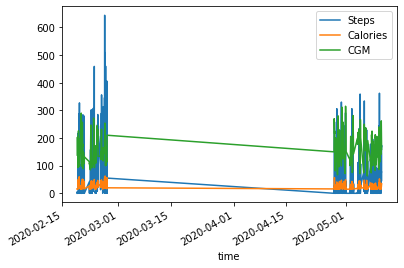

In [12]:
d = get_participant(df_intra, 39)
d.plot(x="time", y=["Steps", "Calories", "CGM"])

Alternatively, we can split the data into two different dataframes (df_before_ramanda and df_ramadan) and analyse them separately with dataprep, for example:

In [13]:
df_before_ramadan = corr_per_day(get_before_ramadan(d))
df_ramadan = corr_per_day(get_ramadan(d))

I could not spot any clear difference between the datasets:

  0%|          | 0/1480 [00:00<?, ?it/s]

DataPrep Report
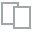
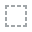
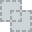
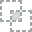
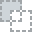
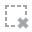
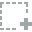
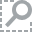
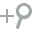
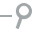
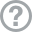
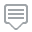
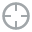
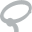
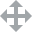
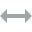
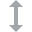
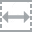
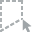
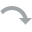
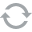
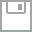
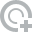
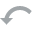
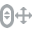
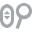
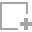
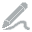
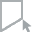
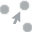
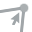
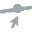

In [14]:
df_ramadan = get_before_ramadan(df_intra).reset_index(drop=True)
if "Ramadan" in df_ramadan:
    del df_ramadan["Ramadan"]

create_report(df_ramadan)

  0%|          | 0/1480 [00:00<?, ?it/s]

DataPrep Report
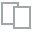
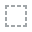
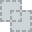
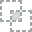
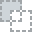
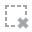
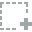
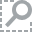
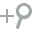
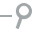
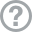
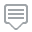
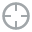
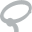
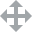
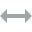
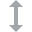
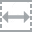
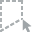
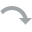
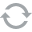
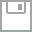
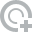
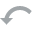
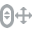
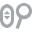
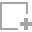
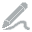
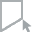
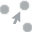
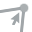
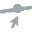

In [15]:
df_ramadan = get_ramadan(df_intra).reset_index(drop=True)
df_ramadan["hypo"] = df_ramadan["hypo"].astype(int)
if "Ramadan" in df_ramadan:
    del df_ramadan["Ramadan"]

create_report(df_ramadan)

## Correlation Analysis

### Correlations at user day

In [16]:
def boxplot_correlation(df, secondary_col, main_col="CGM",
                        pid_col="patientID", time_col="time", 
                        remove_zero_steps=True):

    if remove_zero_steps:
        df_tmp = df[df["Steps"] > 0].copy()
    else:
        df_tmp = df.copy()

    # Get day correlation
    df_tmp["Date"] = df_tmp[time_col].dt.date
    df_tmp = df_tmp.groupby([pid_col, "Date"]).corr().reset_index()
        
    sns.set_theme(style="ticks")
        
    # Plot the orbital period with horizontal boxes
    df_tmp = df_tmp[df_tmp["level_2"] == main_col]
    df_tmp["Ramadan"] = df_tmp["Date"].apply(lambda x: ramadan_flag(x))

    g = sns.boxplot(x=pid_col, y=secondary_col, hue="Ramadan", data=df_tmp)
    sns.stripplot(x=pid_col, y=secondary_col, data=df_tmp,
                  size=4, color=".3", linewidth=0)
    
    g.set(ylabel='Pearson Correlation\n%s-%s' % (main_col, secondary_col))
    
    sns.despine(offset=10, trim=True)
    
    # Move the legend to the right side
    g.legend(title="Ramadan?", bbox_to_anchor=(1.3, 0.5), ncol=1)
    
    return g


<AxesSubplot:xlabel='patientID', ylabel='Pearson Correlation\nCGM-Steps'>

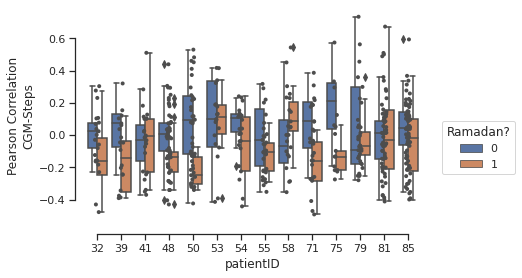

In [17]:
boxplot_correlation(df_intra, "Steps")

<AxesSubplot:xlabel='patientID', ylabel='Pearson Correlation\nCGM-Calories'>

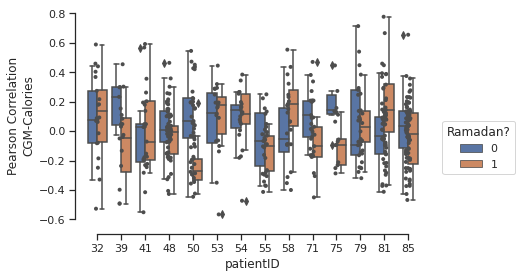

In [18]:
boxplot_correlation(df_intra, "Calories")

<AxesSubplot:xlabel='patientID', ylabel='Pearson Correlation\nCGM-HeartRate'>

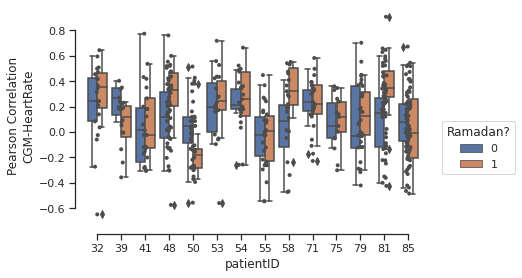

In [19]:
boxplot_correlation(df_intra, "HeartRate")

### Correlations at user level

Next, our aim is to create correlation at user level. For that, we first aggregate the data at day level (e.g., average number of steps in a day) and then average the data at user level (i.e., average number of steps per day for participant X).

For that, we will first load the EMR data and do a few data cleaning steps.

#### Load EMR data, clean and pivot it

In [20]:
df_emr = read_data(SihaEmrDataset, {SihaEmrDataset: "value"})
df_emr = df_emr.pivot(index="patientID", columns="variable", values="value")

emr_cols = ['BMI', 'Cholesterol', 'Creatinine', 'Diabetes Duration',
            'Diastolic Blood Pressure', 'HDL', 'HbA1c', 'LDL', 'Systolic Blood Pressure']

# For some reason this was understood as a string col and we need to replace empty string to NAN manually
df_emr["Diabetes Duration"] = df_emr["Diabetes Duration"].replace('', np.nan)

for emr_col in emr_cols:
    print(emr_col)
    df_emr[emr_col] = df_emr[emr_col].astype(np.float)

df_emr.head()

BMI
Cholesterol
Creatinine
Diabetes Duration
Diastolic Blood Pressure
HDL
HbA1c
LDL
Systolic Blood Pressure


variable    BMI  Cholesterol  Creatinine  Diabetes Duration  \
patientID                                                     
27         28.9          5.1        79.0                6.0   
30         37.8          6.4        65.0               10.0   
31         26.0          3.2        81.0               17.0   
32         33.0          NaN         NaN               11.0   
34         28.7          3.0        96.0                2.0   

variable                                 Diabetes Medication  \
patientID                                                      
27                    Sitagliptin, Glicalzide, Empagliflozin   
30         Metformin, Dapagliflozin, Sitagliptin, Pioglit...   
31         Glargine 300, Sitagliptin, Pioglitazone, Vilda...   
32                      Dapagliflozin, Sitagliptin+Metformin   
34                                Sitagliptin, Empagliflozin   

variable   Diastolic Blood Pressure  HDL  HbA1c  LDL  Systolic Blood Pressure  \
patientID                                                                       
27                             75.0  1.0    8.1  3.1                    121.0   
30                             86.0  1.1    7.8  4.5                    135.0   
31                             96.0  0.9    9.6  1.5                    134.0   
32                             77.0  NaN    7.8  NaN                    142.0   
34                             78.0  0.8   10.0  1.5                    146.0   

variable  Triglyceride  
patientID               
27                   2  
30                 1.7  
31                 1.6  
32                 NaN  
34                 1.5

In [21]:
# Tried to normalize the drug names
drugs = set([])
for tmp in df_emr["Diabetes Medication"]:
    for d in tmp.replace("+", ", ").split(","):
        if d.strip():
            # This should get rid of the dosage (Glargine 300 or Glargine 100 -> Glargine)
            d = d.split()[0].strip()
            drugs.add(d)


print("%d different drugs: %s" % (len(drugs), drugs))

for d in drugs:
    df_emr[d] = df_emr["Diabetes Medication"].apply(lambda x: d in x)

df_emr.head()

14 different drugs: {'Glargine', 'Sitagliptin', 'Vildagliptin', 'Glimepride', 'Pioglitazone', 'Glicalzide', 'Empagliflozin', 'Dapagliflozin', 'Aspart', 'Exenatide', 'Metformin', 'Dulaglutide', 'Degludec', 'Liraglutide'}


variable    BMI  Cholesterol  Creatinine  Diabetes Duration  \
patientID                                                     
27         28.9          5.1        79.0                6.0   
30         37.8          6.4        65.0               10.0   
31         26.0          3.2        81.0               17.0   
32         33.0          NaN         NaN               11.0   
34         28.7          3.0        96.0                2.0   

variable                                 Diabetes Medication  \
patientID                                                      
27                    Sitagliptin, Glicalzide, Empagliflozin   
30         Metformin, Dapagliflozin, Sitagliptin, Pioglit...   
31         Glargine 300, Sitagliptin, Pioglitazone, Vilda...   
32                      Dapagliflozin, Sitagliptin+Metformin   
34                                Sitagliptin, Empagliflozin   

variable   Diastolic Blood Pressure  HDL  HbA1c  LDL  Systolic Blood Pressure  \
patientID                                                                       
27                             75.0  1.0    8.1  3.1                    121.0   
30                             86.0  1.1    7.8  4.5                    135.0   
31                             96.0  0.9    9.6  1.5                    134.0   
32                             77.0  NaN    7.8  NaN                    142.0   
34                             78.0  0.8   10.0  1.5                    146.0   

variable   ... Pioglitazone  Glicalzide  Empagliflozin  Dapagliflozin  Aspart  \
patientID  ...                                                                  
27         ...        False        True           True          False   False   
30         ...         True       False          False           True    True   
31         ...         True       False          False          False   False   
32         ...        False       False          False           True   False   
34         ...        False       False           True          False   False   

variable   Exenatide  Metformin  Dulaglutide  Degludec  Liraglutide  
patientID                                                            
27             False      False        False     False        False  
30             False       True        False     False        False  
31             False       True        False     False        False  
32             False       True        False     False        False  
34             False      False        False     False        False  

[5 rows x 25 columns]

In [22]:
df_agg = pd.concat([mean_per_day(df_intra, "Steps", "MeanSteps", remove_zero_steps=True),
                      sum_per_day(df_intra, "Steps", "SumSteps", remove_zero_steps=True),
                      mean_per_day(df_intra, "Calories", remove_zero_steps=True),
                      sum_per_day(df_intra, "Calories", "SumCalories", remove_zero_steps=True),
                      mean_per_day(df_intra, "Distance", remove_zero_steps=True),
                      sum_per_day(df_intra, "Distance", "SumDistance", remove_zero_steps=True),
                      mean_per_day(df_intra, "mets", remove_zero_steps=True),
                      mean_per_day(df_intra, "HeartRate", remove_zero_steps=True),
                      mean_per_day(df_intra, "CGM", remove_zero_steps=True),
                      mean_per_day(df_intra, "hypo", "AvgHypo", remove_zero_steps=True),
                      sum_per_day(df_intra, "hypo", "TotalHypo", remove_zero_steps=True),
                      mean_per_day(df_intra, "hyper", "AvgHyper", remove_zero_steps=True),
                      sum_per_day(df_intra, "hyper", "TotalHyper", remove_zero_steps=True),
                      mean_per_day(df_intra, "Ramadan", "IsRamadan", remove_zero_steps=True),
                      ], axis=1).reset_index()
df_means = df_agg.groupby("patientID").mean()
df_means.head()

MeanSteps     SumSteps   Calories  SumCalories  Distance  \
patientID                                                              
32         121.105591  6025.333496  50.556847  2539.665771  0.059519   
39          97.832428  3463.736816  28.477617   980.619995  0.041499   
41         122.701607  4045.250000  53.818687  1906.372559  0.058185   
48         100.830505  4140.887207  27.874519  1152.474976  0.032886   
50         132.719299  5808.155762  45.185219  1956.943115  0.061840   

           SumDistance        mets  HeartRate         CGM   AvgHypo  \
patientID                                                             
32            2.961275  340.060849  84.007599  125.269157  0.016807   
39            1.469370  287.885337  98.240784  176.231445  0.000000   
41            1.917922  381.774038  87.760277  113.726624  0.016226   
48            1.350531  283.883487  86.630280  135.871185  0.001315   
50            2.706337  326.035208  78.442734  104.788094  0.147368   

           TotalHypo  AvgHyper  TotalHyper  IsRamadan  
patientID                                              
32          0.809524  0.067380    3.333333   0.380952  
39          0.000000  0.481490   15.052632   0.631579  
41          0.458333  0.010101    0.333333   0.541667  
48          0.064516  0.099966    4.451613   0.354839  
50          6.400000  0.033342    1.488889   0.311111

In [23]:
df_merged = pd.merge(df_means, df_emr, left_index=True, right_index=True)
df_merged.head()

MeanSteps     SumSteps   Calories  SumCalories  Distance  \
patientID                                                              
32         121.105591  6025.333496  50.556847  2539.665771  0.059519   
39          97.832428  3463.736816  28.477617   980.619995  0.041499   
48         100.830505  4140.887207  27.874519  1152.474976  0.032886   
50         132.719299  5808.155762  45.185219  1956.943115  0.061840   
53         159.439255  6482.600098  35.390106  1410.535645  0.069389   

           SumDistance        mets  HeartRate         CGM   AvgHypo  ...  \
patientID                                                            ...   
32            2.961275  340.060849  84.007599  125.269157  0.016807  ...   
39            1.469370  287.885337  98.240784  176.231445  0.000000  ...   
48            1.350531  283.883487  86.630280  135.871185  0.001315  ...   
50            2.706337  326.035208  78.442734  104.788094  0.147368  ...   
53            2.821783  309.895863  86.437775  108.562859  0.004402  ...   

           Pioglitazone  Glicalzide  Empagliflozin  Dapagliflozin  Aspart  \
patientID                                                                   
32                False       False          False           True   False   
39                 True       False          False          False   False   
48                False       False           True          False   False   
50                False       False          False          False   False   
53                 True       False          False           True   False   

           Exenatide  Metformin  Dulaglutide Degludec  Liraglutide  
patientID                                                           
32             False       True        False    False        False  
39             False       True        False    False        False  
48             False       True        False    False        False  
50             False       True        False    False        False  
53             False       True        False    False        False  

[5 rows x 39 columns]

In [24]:
for d in drugs:
    df_drug = df_merged[df_merged[d] == True]
    print("People in the final dataset that took drug %s: %d" % (d, df_drug.shape[0]))

People in the final dataset that took drug Glargine: 4
People in the final dataset that took drug Sitagliptin: 8
People in the final dataset that took drug Vildagliptin: 3
People in the final dataset that took drug Glimepride: 1
People in the final dataset that took drug Pioglitazone: 4
People in the final dataset that took drug Glicalzide: 1
People in the final dataset that took drug Empagliflozin: 2
People in the final dataset that took drug Dapagliflozin: 5
People in the final dataset that took drug Aspart: 1
People in the final dataset that took drug Exenatide: 0
People in the final dataset that took drug Metformin: 12
People in the final dataset that took drug Dulaglutide: 1
People in the final dataset that took drug Degludec: 2
People in the final dataset that took drug Liraglutide: 2


We are now able to compare the correlation between any number of groups.
For example, below we verify that the correlation between average CGM and HeartRate was strong for participants taking the combo of Metformin and Sitagliptin, while it was the opposite for participants not taking these drugs. 

⭐️⭐️⭐️ <b> TODO: we need to know what kind of medicament combination is important! </b> ⭐️⭐️⭐️

In [25]:
# Compared the data for the 8 people with combo ["Metformin", "Sitagliptin"] against without (4)
df_grp1 = df_merged[((df_merged["Metformin"] == True) & (df_merged["Sitagliptin"] == True))]
df_grp2 = df_merged[~((df_merged["Metformin"] == True) & (df_merged["Sitagliptin"] == True))]

print("Corr CGM-HeartRate Grp1: %.3f, Grp2: %.3f" % (df_grp1.corr()["CGM"]["HeartRate"],
                                                     df_grp2.corr()["CGM"]["HeartRate"]))

Corr CGM-HeartRate Grp1: 0.881, Grp2: -0.287


Before moving to the next section, we save a postprocessed dataframe to disk in order to speed up futher ML pipelines.

In [26]:
profast_ml = os.path.join(profast_datapath, "preprocessed")
if not os.path.exists(profast_ml):
    os.mkdir(profast_ml)

df_intra.to_csv(os.path.join(profast_ml, "data.csv.gz"), index=False)

## 2 - Machine Learning for CGM Prediction

This second part of this notebook used the preprocessed data from profast 2020 for CGM prediction.
Note that we can move this section elsewhere without problem if this notebook becomes too extense.
For that, we start by loading the preprocessed data.

In [27]:
df = pd.read_csv(os.path.join(profast_ml, "data.csv.gz"))
df["time"] = pd.to_datetime(df["time"])
df.head()

patientID                time  HeartRate  level   mets  Calories  Steps  \
0         32 2020-02-17 10:30:00  88.266670    1.0  616.0  91.58072  408.0   
1         32 2020-02-17 10:45:00  75.933334    1.0  234.0  34.78878   22.0   
2         32 2020-02-17 11:00:00  75.066666    1.0  440.0  65.41480  309.0   
3         32 2020-02-17 11:15:00  76.600000    1.0  282.0  41.92494  106.0   
4         32 2020-02-17 11:30:00  83.466670    1.0  339.0  50.39913  170.0   

   Distance    CGM  Ramadan  hypo  hyper  
0  0.200765  128.0        0     0      0  
1  0.010750  128.5        0     0      0  
2  0.151863  171.0        0     0      0  
3  0.052071  176.0        0     0      0  
4  0.083574  172.0        0     0      0

In [50]:
from sklearn.model_selection import LeaveOneGroupOut, KFold, GroupKFold

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import extract_relevant_features
from pycaret.regression import *

Next, following the idea of [this tensorflow tutorial on time_series analysis](https://www.tensorflow.org/tutorials/structured_data/time_series), we transformed time of the day into a continous sin/cos cyclic feature.

<AxesSubplot:>

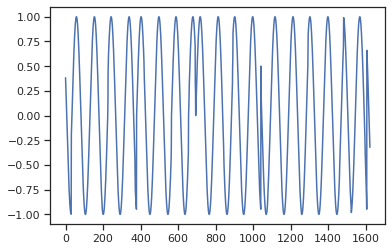

In [29]:
def convert_time_sin_cos(df, datetime_col):

    day = 24*60*60
    
    ts = df[datetime_col].apply(lambda x: x.timestamp()).astype(int)
    day_sin = np.sin(ts * (2 * np.pi / day))
    day_cos = np.cos(ts * (2 * np.pi / day))
    
    return day_sin, day_cos
    
    
df["time_sin"], df["time_cos"] = convert_time_sin_cos(df, "time")

df[df["patientID"] == 32]["time_sin"].plot()


In [116]:
def generate_slide_wins(df_in, start_seq=0, winsize="1h15t", time_col="time", 
                        label_col="CGM", pid_col="patientID"):
    """
    From a timeseries of ONE participant, this function generates two dataframes: <time_series_features>, <labels>
    The first dataframe can be used with tsfresh later on, while the second has all the labels that we want to predict.

    Notice that the default winsize is 1h and 15 minutres (`1h15t`).
    We used the first hour to extract the features and the 15 min only to collect the ground_truth labels.

    """
    seq_id = start_seq
    transformed_df = []
    list_of_indices = []
    labels = []
    label_times = []

    pid = df_in[pid_col].unique()
    if len(pid) > 1:
        print("ERROR: We should have only one pid here. Aborting")
        return
    pid = pid[0]
    
    df = df_in.reset_index(drop=True).copy()
    
    # The following code will construct a rolling win that could be based on either time or #win
    # This will feed list_of_indexes with the sub-win indices that will be used in the next for loop
    df.reset_index().rolling(winsize, on=time_col, center=False)["index"].apply((lambda x: list_of_indices.append(x.tolist()) or 0))

    # Time-based win might be smaller than the expected size. We fix it by comparing the size of each
    # value in the list_of_indices with the size of the last element
    max_size = len(list_of_indices[-1])

    
    for idx in list_of_indices:
        if len(idx) != max_size:
            continue

        labels.append(df.loc[idx].iloc[-1][label_col])
        label_times.append(df.loc[idx].iloc[-1][time_col])
        
        tmp_df = df.loc[idx[0:-1]].copy()
        tmp_df["seq_id"] = seq_id
        seq_id += 1

        del tmp_df[pid_col]
        
        transformed_df.append(tmp_df)

    labels = pd.Series(labels)
    labels.name = "ground_truth"
    
    label_times = pd.Series(label_times)
    label_times.name = "gt_time"
    
    transformed_df = pd.concat(transformed_df).reset_index(drop=True)
    pid = pd.Series([pid] * labels.shape[0])
    pid.name = "pid"
    
    return seq_id, transformed_df, labels, label_times, pid

In [202]:
generate_slide_wins(df.head(22), start_seq=0, winsize="3h15t")

(10,
                    time  HeartRate  level   mets  Calories  Steps  Distance  \
 0   2020-02-17 10:30:00  88.266670    1.0  616.0  91.58072  408.0  0.200765   
 1   2020-02-17 10:45:00  75.933334    1.0  234.0  34.78878   22.0  0.010750   
 2   2020-02-17 11:00:00  75.066666    1.0  440.0  65.41480  309.0  0.151863   
 3   2020-02-17 11:15:00  76.600000    1.0  282.0  41.92494  106.0  0.052071   
 4   2020-02-17 11:30:00  83.466670    1.0  339.0  50.39913  170.0  0.083574   
 ..                  ...        ...    ...    ...       ...    ...       ...   
 115 2020-02-17 14:30:00  79.200000    0.0  203.0  30.18001    0.0  0.000000   
 116 2020-02-17 14:45:00  73.000000    0.0  181.0  26.90927    0.0  0.000000   
 117 2020-02-17 15:00:00  69.733330    0.0  180.0  26.76060    0.0  0.000000   
 118 2020-02-17 15:15:00  68.066666    0.0  176.0  26.16592    0.0  0.000000   
 119 2020-02-17 15:30:00  70.933334    0.0  216.0  32.11272   26.0  0.012738   
 
        CGM  Ramadan  hypo  hyper

Different winsizes will render different number of epochs. 
For example, if we do not have continous CGM recorded for 5 hours, we cannot generate features with a winsize bigger than 4:45min.


100%|██████████| 14/14 [00:50<00:00,  3.60s/it]


<AxesSubplot:xlabel='winsize'>

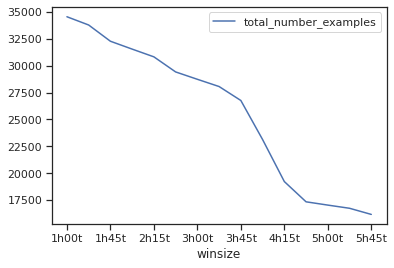

In [286]:
winsizes = ["%dh%02dt" % (hour, minute) for hour in range(1, 6) for minute in [0, 15, 45] ]

df_result = []
for winsize in winsizes:
    df_timeseries = []
    row = {}
    last_seq = 0
    for pid in tqdm(df["patientID"].unique()):
        df_tmp = df[df["patientID"] == pid]
        last_seq, df_ts_tmp, _, _, _ = generate_slide_wins(df_tmp[["patientID", "time", "CGM"]], start_seq=last_seq, winsize=winsize)
        df_timeseries.append(df_ts_tmp)
    
    row["winsize"] = winsize
    row["total_number_examples"] = last_seq
    df_result.append(row)
    
pd.DataFrame(df_result).set_index("winsize").plot()

In [203]:
signals = ["time", "patientID", "time_sin", "time_cos", 
           "HeartRate", "mets", "Calories", "Steps", "Distance", "CGM"]

winsize = "3h15t"

df_labels = []
df_label_time = []
df_timeseries = []
df_pids = []

last_seq_id = 0

for pid in tqdm(df["patientID"].unique()):

    df_tmp = df[df["patientID"] == pid]

    last_seq_id, df_ts_tmp, df_label_tmp, df_label_time_tmp, df_pid = generate_slide_wins(df_tmp[signals],
                                                                                          start_seq=last_seq_id,
                                                                                          winsize=winsize)
    df_timeseries.append(df_ts_tmp)
    df_labels.append(df_label_tmp)
    df_label_time.append(df_label_time_tmp)
    df_pids.append(df_pid)
    

df_labels = pd.concat(df_labels).reset_index(drop=True)
df_label_time = pd.concat(df_label_time).reset_index(drop=True)
df_timeseries = pd.concat(df_timeseries).reset_index(drop=True)

df_pids = pd.concat(df_pids).reset_index(drop=True)
df_pids.name = "pid"

100%|██████████| 14/14 [01:21<00:00,  5.81s/it]


In [204]:
if os.path.exists(os.path.join(profast_ml, "extracted_features_%s.csv.gz" % (winsize))):
    extracted_feature = pd.read_csv(os.path.join(profast_ml, "extracted_features_%s.csv.gz" % (winsize)))
else:
    extracted_features = extract_features(df_timeseries, column_id="seq_id", column_sort="time")
    extracted_features.to_csv(os.path.join(profast_ml, "extracted_features_%s.csv.gz" % (winsize)), index=False)

Feature Extraction: 100%|██████████| 30/30 [26:16<00:00, 52.54s/it]  


In [205]:
if os.path.exists(os.path.join(profast_ml, "filtered_features_%s.csv.gz" % (winsize))):
    features_filtered = pd.read_csv(os.path.join(profast_ml, "filtered_features_%s.csv.gz" % (winsize)))
else:
    impute(extracted_features)
    features_filtered = extract_relevant_features(df_timeseries, df_labels, column_id='seq_id', column_sort='time')
    features_filtered.to_csv(os.path.join(profast_ml, "filtered_features_%s.csv.gz" % (winsize)), index=False)

Feature Extraction: 100%|██████████| 30/30 [26:08<00:00, 52.29s/it]  


In [206]:
assert features_filtered.shape[0] == df_labels.shape[0]

In [207]:
data = pd.concat([df_pids, df_labels, features_filtered], axis=1)
data = data.merge(df_emr, left_on="pid", right_index=True)

print("Note that there were many NAN in the ERM files.")
print("If we dropall NAN, we go from %d rows to %d (i.e., from %d to %d participants)" % (data.shape[0], 
                                                                                          data.dropna().shape[0],
                                                                                          data["pid"].unique().shape[0],
                                                                                          data.dropna()["pid"].unique().shape[0]))

print("So, lets dropping NAs...")

data = data.dropna()


Note that there were many NAN in the ERM files.
If we dropall NAN, we go from 23445 rows to 15281 (i.e., from 12 to 8 participants)
So, lets dropping NAs...


In [208]:
# TODO: add other time relateted features (isRamadan, day_sin, day_cos)

Next we map all features to a dictionary called feature_mapping. 
Later, this will help us to build models using different feature sets.
Example ``model(data[feature_mapping["Steps"]])`` would create a model only using "Steps".

In [209]:
feature_mapping = {}
mapped_feature = set([])

for feature in signals:
    for k in data.keys():
        if k.startswith(feature):
            if feature not in feature_mapping:
                feature_mapping[feature] = []
            feature_mapping[feature].append(k)            
            mapped_feature.add(k)

feature_mapping["other"] = []
for k in data.keys():
    if k not in mapped_feature and k not in ['pid', 'ground_truth']:
        feature_mapping["other"].append(k)
            
feature_mapping

{'time': ['time_sin__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2',
  'time_sin__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0',
  'time_cos__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2',
  'time_cos__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0',
  'time_cos__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0',
  'time_cos__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0',
  'time_cos__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0',
  'time_cos__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2',
  'time_sin__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0',
  'time_sin__ar_coefficient__coeff_8__k_10',
  'time_sin__ar_coefficient__coeff_9__k_10',
  'time_cos__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0',
  'time_sin__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2',
  'time_cos__spkt_welch_density__coeff_2',
  'time_cos__spkt_welch_density__coeff_5',
  

In [210]:
df_emr.keys() # ["Cholesterol"]# astype(np.float)

Index(['BMI', 'Cholesterol', 'Creatinine', 'Diabetes Duration',
       'Diabetes Medication', 'Diastolic Blood Pressure', 'HDL', 'HbA1c',
       'LDL', 'Systolic Blood Pressure', 'Triglyceride', 'Glargine',
       'Sitagliptin', 'Vildagliptin', 'Glimepride', 'Pioglitazone',
       'Glicalzide', 'Empagliflozin', 'Dapagliflozin', 'Aspart', 'Exenatide',
       'Metformin', 'Dulaglutide', 'Degludec', 'Liraglutide'],
      dtype='object', name='variable')

In [211]:
data[["pid", "ground_truth"] + feature_mapping["Steps"]].head(5)

pid  ground_truth  \
1362   39         139.0   
1363   39         131.0   
1364   39         118.0   
1365   39         107.0   
1366   39          98.0   

      Steps__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)  \
1362                                           0.294926              
1363                                          -0.266882              
1364                                           0.000000              
1365                                           0.000000              
1366                                           0.000000              

      Steps__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)  \
1362                                           0.929001              
1363                                           0.294926              
1364                                          -0.266882              
1365                                           0.000000              
1366                                           0.000000              

      Steps__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)  \
1362                                          -0.266882              
1363                                           0.000000              
1364                                           0.000000              
1365                                           0.000000              
1366                                           0.000000              

      Steps__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)  \
1362                                           0.986712               
1363                                           0.000000               
1364                                           0.000000               
1365                                           0.000000               
1366                                           0.000000               

      Steps__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)  \
1362                                                0.0               
1363                                                0.0               
1364                                                0.0               
1365                                                0.0               
1366                                                0.0               

      Steps__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)  \
1362                                                0.0               
1363                                                0.0               
1364                                                0.0               
1365                                                0.0               
1366                                                0.0               

      Steps__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)  \
1362                                           1.186019               
1363                                           0.986712               
1364                                           0.000000               
1365                                           0.000000               
1366                                           0.000000               

      Steps__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)  ...  \
1362                                           1.035725              ...   
1363                                           0.000000              ...   
1364                                           0.000000              ...   
1365                                           0.000000              ...   
1366                                           0.000000              ...   

      Steps__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"  \
1362                                          -0.866025                  
1363                                          -0.866025                  
1364                                          -0.866025                  
1365                                           0.000000                  
1366                                         

In [212]:
def map_id_fold(all_ids, n, pid_col="pid"):
    
    pids = all_ids[pid_col].unique().ravel()
    if n < 0:
        n = len(pids)
    
    kf = KFold(n_splits=n, shuffle=True, random_state=42)
    mapping = []
    for i, (_, test) in enumerate(kf.split(pids)):
        for pid_index in test:
            mapping.append({'fold': i, pid_col: pids[pid_index]})

    return pd.DataFrame(mapping)

In [213]:
df_folds = map_id_fold(data, -1)
df_folds.head(10)

fold  pid
0     0   50
1     1   75
2     2   39
3     3   81
4     4   53
5     5   58
6     6   54
7     7   79

In [214]:
data = pd.merge(df_folds, data)
data.head()

fold  pid  ground_truth  HeartRate__quantile__q_0.1  \
0     0   50          57.5                   88.379999   
1     0   50          56.0                   91.208571   
2     0   50          56.5                   91.717139   
3     0   50          55.5                   91.390473   
4     0   50          53.0                   92.740002   

   CGM__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)  \
0                                         151.075204            
1                                         142.532703            
2                                         134.646617            
3                                         128.642634            
4                                         124.316051            

   CGM__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)  \
0                                          33.579610            
1                                          30.315396            
2                                          29.566395            
3                                          29.158376            
4                                          29.184072            

   HeartRate__quantile__q_0.8  HeartRate__quantile__q_0.7  \
0                   98.946670                   96.778098   
1                   98.946670                   96.778098   
2                   99.280002                   98.033332   
3                   99.280002                   98.033332   
4                   99.360003                   98.813333   

   HeartRate__quantile__q_0.6  HeartRate__quantile__q_0.4  ...  Pioglitazone  \
0                   96.542858                   95.920000  ...         False   
1                   96.542858                   96.426668  ...         False   
2                   96.748574                   96.480002  ...         False   
3                   96.748574                   96.480002  ...         False   
4                   97.866666                   96.528572  ...         False   

   Glicalzide  Empagliflozin  Dapagliflozin  Aspart  Exenatide  Metformin  \
0       False          False          False   False      False       True   
1       False          False          False   False      False       True   
2       False          False          False   False      False       True   
3       False          False          False   False      False       True   
4       False          False          False   False      False       True   

   Dulaglutide  Degludec  Liraglutide  
0        False     False        False  
1        False     False        False  
2        False     False        False  
3        False     False        False  
4        False     False        False  

[5 rows x 2103 columns]

In [216]:
def get_cols_by_featureset(data, featset, feature_mapping):
    acc_feats = []
    for f in featset:
        acc_feats.extend(feature_mapping[f])
        
    return ["pid", "ground_truth", "fold"] + acc_feats


In [242]:
feature_sets = [['mets', 'Calories', 'Steps', 'Distance', 'CGM'],
               ['mets', 'Calories', 'Steps', 'Distance'], 
               ['mets', 'Calories', 'Steps', 'Distance', 'CGM', 'other'],
               ['mets', 'Calories', 'Steps', 'Distance', 'other'], 
              ]

results = []
for featset in feature_sets:
    train_data = data[get_cols_by_featureset(data, featset, feature_mapping)]
    last_fold = train_data["fold"].max()
    test_data = train_data[train_data["fold"] == last_fold]
    train_data = train_data[train_data["fold"] != last_fold]
    
    cv = GroupKFold()
    
    experiment = setup(data = train_data, test_data = test_data,
                       target='ground_truth', session_id=42, silent=True,
                       fold_strategy = cv, fold_groups = 'fold',
                       fold = last_fold-1,
                       ignore_features = ["pid"]
                      )
    
    best_model = compare_models(include=['llar', 'lr', 'omp'], n_select=1)
    create_model(best_model)
    result = pull()
    
    row = {}
    row["featset"] = featset
    row["r2"] = result.loc["Mean"]["R2"]
    row["rmse"] = result.loc["Mean"]["RMSE"]
    row["name"] = best_model
    results.append(row)
    
pd.DataFrame(results)

create_model_container: 4
master_model_container: 4
display_container: 3
LassoLars(alpha=1.0, copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
          fit_path=True, jitter=None, max_iter=500, normalize=True,
          positive=False, precompute='auto', random_state=42, verbose=False)
create_model() succesfully completed......................................


featset      r2     rmse  \
0         [mets, Calories, Steps, Distance, CGM]  0.9598   7.7964   
1              [mets, Calories, Steps, Distance] -0.3786  46.8585   
2  [mets, Calories, Steps, Distance, CGM, other]  0.9593   7.8439   
3       [mets, Calories, Steps, Distance, other] -0.3786  46.8585   

                                                name  
0  OrthogonalMatchingPursuit(fit_intercept=True, ...  
1  LassoLars(alpha=1.0, copy_X=True, eps=2.220446...  
2  OrthogonalMatchingPursuit(fit_intercept=True, ...  
3  LassoLars(alpha=1.0, copy_X=True, eps=2.220446...